In [215]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import torch
from torch import nn
import copy
from IPython.html import widgets
from IPython.display import display, clear_output

from screen_utils import *
from cv_utils import *

In [205]:
def gen_training_data(fps, video_len, initial_wait=1.5):
    time.sleep(initial_wait)
    
    window_coords = get_window_coords()
    window_width = window_coords[2] - window_coords[0]
    window_height = window_coords[3] - window_coords[1]

    tracker = ObjectTracker(300, 3000, time_threshold=fps//2, n_hist=fps)

    train_image_buffer = []
    
    for i in range(int(video_len * fps)):
        prev_time = time.time()
        window_pixels = grab_area(*window_coords)
        mask = get_cow_mask(window_pixels)
        
        bounding_boxes = get_bounding_boxes(mask)
        objects = tracker.add_frame(bounding_boxes)

        obj_centers = set(objects.values())
        for bounding_box in bounding_boxes:
            if bounding_box[0] in obj_centers:
                x, y, width, height = bounding_box[1]
                cropped_img = window_pixels[y:y+height, x:x+width]
                if 0 in cropped_img.shape:
                    print(cropped_img.shape, bounding_box[1])
                train_image_buffer.append(cropped_img)

        while time.time() - prev_time < 1./fps:
            time.sleep(0.001)
            
    return train_image_buffer

In [207]:
FPS = 0.5
VIDEO_LEN = 120 # Seconds
train_imgs = gen_training_data(FPS, VIDEO_LEN, initial_wait=1.5)

In [208]:
len(train_imgs)

173

Button(description='Cow', style=ButtonStyle())

Button(description='NOT Cow', style=ButtonStyle())

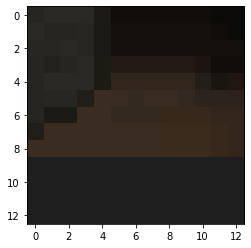

In [222]:
img_idx = 0
cow_idx = 0
not_cow_idx = 0
labels = []

cow_button = widgets.Button(description='Cow')
not_cow_button = widgets.Button(description='NOT Cow')

def display_next():
    global img_idx
    
    clear_output()
    plt.imshow(train_imgs[img_idx])
    
    display(cow_button)
    display(not_cow_button)
    
display_next()

def on_cow_click(b):
    global img_idx
    global cow_idx
    
    labels.append(1)
    cv2.imwrite(f'data/cow/cow_{cow_idx}.png', cv2.cvtColor(train_imgs[img_idx], cv2.COLOR_RGB2BGR))
    
    img_idx += 1
    cow_idx += 1
    
    display_next()
    
def on_not_cow_click(b):
    global img_idx
    global not_cow_idx
    
    labels.append(0)
    cv2.imwrite(f'data/not_cow/not_cow_{not_cow_idx}.png', cv2.cvtColor(train_imgs[img_idx], cv2.COLOR_RGB2BGR))
    
    img_idx += 1
    not_cow_idx += 1
    
    display_next()
    
cow_button.on_click(on_cow_click)
not_cow_button.on_click(on_not_cow_click)

In [212]:
# Training code source: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

data_dir = "./data/"
model_name = "vgg" # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 2
batch_size = 32
num_epochs = 15
feature_extract = True

In [213]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [217]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# print(model_ft)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")